# 

# About data cleaning for own language 
---

## Learning Objectives
- **The goal of this lab is to go through some basic data cleansing methods which should be cautiously applied to own langauge dataset  **
    - langauge detection and filtering 
    - finding sentence boundary, and give some examples :
    it is importance to be able to find good sentence boundary per given document, see [Megatron-LM/tools/preprocess_data.py](https://github.com/NVIDIA/Megatron-LM/blob/main/tools/preprocess_data.py#L84)
        1. [sentence-splitter](https://github.com/mediacloud/sentence-splitter)
        2. [NLTK](https://github.com/nltk/nltk)
        3. write your own sentence splitter, a home-made example
    - deduplicate documents based on similarity score
    - (additional advice) discuss filtering on number of sentences per document and number of tokens per sentence 
        - example for English GPT training, it is recommand to check on the stats of your raw data and come-up with a good rule-of-thumb to proceed filtering, it is,however,recommanded to look into language-specific cleaning and follow up robust clearning procedure to obtain quality corpus.

in this notebook, we will embrace the method provided by the [Megatron-LM repo](https://github.com/NVIDIA/Megatron-LM/tree/main/tools/openwebtext) as well as introduce other complimenting methods that might be of interest for data cleaning.

---------------
### At the end, there's a **mini challenge** for hands-on practice identifying number of duplicates approach groudtruth number!

--------------------------------------------------------------------------------------------------------------------
#### start by install necessary libraries -

    install LSH - 

    follow instruction from [Megatron-LM/tools/openwebtext/README](https://github.com/NVIDIA/Megatron-LM/tree/main/tools/openwebtext) in openwebtext clearning folder 

    note : in a restricted environment where sudo is not allowed, please follow the below instruction to modify installation
        
            git clone https://github.com/mattilyra/LSH
            cd LSH
            open setup.py in an editor and modify as below
   ![modify setup.py line 6](./LSH_modification_setup.JPG)

            python setup.py install --user 

In [2]:
!pip install ftfy langdetect numpy torch pandas nltk sentencepiece boto3 tqdm regex bs4 htmlmin tldextract sentence-splitter

Defaulting to user installation because normal site-packages is not writeable


-------------------------------------------------------------------------------
## detect and filter undesired langauge in the raw text corpus

In [3]:
from langdetect import detect
swe_raw_text='Under fredagsförmiddagen höll polis och räddningstjänst presskonferens tillsammans med en representanter från flygplatsens egna räddningsenhet och Örebro kommun.'
detect(swe_raw_text)

'sv'

In [4]:
danish_text='1. januar 2021 var folketallet 5.840.045. Ved den første folketælling i 1735 var der 718.000 danskere.'
detect(danish_text)

'da'

In [5]:
finnish_text='Jokaisella on oikeus vapaasti osallistua yhteiskunnan sivistyselämään, nauttia taiteista sekä päästä osalliseksi tieteen edistyksen mukanaan tuomista eduista.'
detect(finnish_text)

'fi'

-----------------------------------------------------------
## finding sentence boundary - NLTK

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/zcharpy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [1]:
import nltk
from nltk.tokenize import sent_tokenize
text='På sommarhalvåret längst vattnet och i skogarna på Lidingö eller på Djurgården – på vintern blir det löpbandet på gymmet .Händelsen skapade mycket oro inom klubben , eftersom skridskoåkning äger rum på sjöar och vattendrag där det givetvis inte finns någon gatuadress att uppge vid olycka .'
print("original doc is :\n ", text)
sents=sent_tokenize(text)
i=0
for sent in sents:
    print("------- sentence {} -------".format(str(i)))    
    print(sent)
    i+=1

original doc is :
  På sommarhalvåret längst vattnet och i skogarna på Lidingö eller på Djurgården – på vintern blir det löpbandet på gymmet .Händelsen skapade mycket oro inom klubben , eftersom skridskoåkning äger rum på sjöar och vattendrag där det givetvis inte finns någon gatuadress att uppge vid olycka .
------- sentence 0 -------
På sommarhalvåret längst vattnet och i skogarna på Lidingö eller på Djurgården – på vintern blir det löpbandet på gymmet .Händelsen skapade mycket oro inom klubben , eftersom skridskoåkning äger rum på sjöar och vattendrag där det givetvis inte finns någon gatuadress att uppge vid olycka .


-----------------------------------------------------------
## finding sentence boundary - Sentence-Splitter

In [2]:
from sentence_splitter import SentenceSplitter, split_text_into_sentences
splitter = SentenceSplitter(language='sv', non_breaking_prefix_file='custom_english_non_breaking_prefixes.txt')
sents=splitter.split(text=text)
i=0
for sent in sents:
    print("------- sentence {} -------".format(str(i)))  
    print(sent)
    i+=1

------- sentence 0 -------
På sommarhalvåret längst vattnet och i skogarna på Lidingö eller på Djurgården – på vintern blir det löpbandet på gymmet .Händelsen skapade mycket oro inom klubben , eftersom skridskoåkning äger rum på sjöar och vattendrag där det givetvis inte finns någon gatuadress att uppge vid olycka .


-----------------------------------------------------------
## finding sentence boundary - create your own sentence splitter

In [9]:
import re
import nltk
from nltk.tokenize import sent_tokenize
def normal_cut_sentence(temp):
    return sent_tokenize(temp)

def cut_sentence_with_quotation_marks(text):
    p = re.compile("“.*?”")
    list = []
    index = 0
    length = len(text)
    for i in p.finditer(text):
        temp = ''
        start = i.start()
        end = i.end()
        for j in range(index, start):
            temp += text[j]
        if temp != '':
            temp_list = normal_cut_sentence(temp)
            list += temp_list
        temp = ''
        for k in range(start, end):
            temp += text[k]
        if temp != ' ':
            list.append(temp)
        index = end
    return list

In [10]:
sample_doc='Andersson pekas ut som nästa partiledare: “Medlemmarna ska säga sitt”'
sents=cut_sentence_with_quotation_marks(sample_doc)
for sent in sents:
    print("------- sentence {} -------".format(str(i)))  
    print(sent)
    i+=1

------- sentence 3 -------
Andersson pekas ut som nästa partiledare:
------- sentence 4 -------
“Medlemmarna ska säga sitt”


-----------------------------------------------------------
## deduplicate text based on similarity score  

In [1]:
import itertools
from lsh import cache, minhash # https://github.com/mattilyra/lsh

# a pure python shingling function that will be used in comparing
# LSH to true Jaccard similarities
def shingles(text, char_ngram=5):
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))


def jaccard(set_a, set_b):
    intersection = set_a & set_b
    union = set_a | set_b
    return len(intersection) / len(union)


def candidate_duplicates(document_feed, char_ngram=5, seeds=100, bands=5, hashbytes=4):
    char_ngram = 5
    sims = []
    hasher = minhash.MinHasher(seeds=seeds, char_ngram=char_ngram, hashbytes=hashbytes)
    if seeds % bands != 0:
        raise ValueError('Seeds has to be a multiple of bands. {} % {} != 0'.format(seeds, bands))
    
    lshcache = cache.Cache(num_bands=bands, hasher=hasher)
    for i_line, line in enumerate(document_feed):
        line = line.decode('utf8')
        docid, headline_text = line.split('\t', 1)
        fingerprint = hasher.fingerprint(headline_text.encode('utf8'))
        
        # in addition to storing the fingerpring store the line
        # number and document ID to help analysis later on
        lshcache.add_fingerprint(fingerprint, doc_id=(i_line, docid))

    candidate_pairs = set()
    for b in lshcache.bins:
        for bucket_id in b:
            if len(b[bucket_id]) > 1:
                pairs_ = set(itertools.combinations(b[bucket_id], r=2))
                candidate_pairs.update(pairs_)
    
    return candidate_pairs

In [2]:
# given two documents 
doc1='I det här fallet fungerar kursen som en hjälp till elever.'
shingles_1 = [doc1[i:i+5] for i in range(len(doc1))][:-5]
doc2='På det sättet fungerar kursen som en hjälp till elever.'
shingles_2 = [doc2[i:i+5] for i in range(len(doc2))][:-5]

In [3]:
from lsh import minhash
for _ in range(5):
    hasher = minhash.MinHasher(seeds=100, char_ngram=5)
    fingerprint0 = hasher.fingerprint(doc1.encode('utf8'))
    fingerprint1 = hasher.fingerprint(doc2.encode('utf8'))
    print(sum(fingerprint0[i] in fingerprint1 for i in range(hasher.num_seeds)) / hasher.num_seeds)

0.58
0.6
0.68
0.56
0.71


## dataset extracted from NVIDIA blog urls 

In [2]:
import pandas as pd
cols=['doc1']
df=pd.read_csv('../../../../dataset/EN/extractedNVblogs.txt',sep='\n', names=cols ,skiprows=1)
df.head()

,doc1
0,"Today, NVIDIA announced new pretrained models ..."
1,"This post was updated July 20, 2021 to reflect..."
2,"In part 1 of this series, we introduced new AP..."
3,The NVIDIA NGC team is hosting a webinar with ...
4,NVIDIA announces our newest release of the CUD...


## create our own groudtruth dataset

In [43]:
import numpy as np

def create_duplicates(df):
    doc2=[]
    duplicate=[]
    n=len(df)
    for i in range(n):
        other_population=[k for k in range(n) if k!=i]
        
        other_idx=np.random.choice(other_population)
        current_idx=np.random.choice([i,other_idx], p=[0.25,0.75])
        if current_idx==i:            
            duplicate.append(True)
        else:
            duplicate.append(False)
        doc2.append(df.iloc[current_idx,0])
    df['index']=df.index
    df['doc2']=doc2
    df['duplicate']=duplicate
    cols=['index','doc1','doc2','duplicate']
    df=df[cols]
    return df 

In [49]:
df2=create_duplicates(df)
df2.tail()

,index,doc1,doc2,duplicate
68,68,Despite substantial progress in natural langua...,NVIDIA and Mozilla are proud to announce the l...,False
69,69,"Engineers, product developers and designers ar...","Engineers, product developers and designers ar...",True
70,70,NVIDIA NeMo is a conversational AI toolkit bui...,"Today, in partnership with NVIDIA, Google Clou...",False
71,71,"In NVIDIA Clara Train 4.0, we added homomorphi...","In NVIDIA Clara Train 4.0, we added homomorphi...",True
72,72,Targeting areas populated with disease-carryin...,Targeting areas populated with disease-carryin...,True


In [45]:
del df
keep_cols_to_write=['index','doc1','doc2']
df3=df2[keep_cols_to_write]
df3.head()

,index,doc1,doc2
0,0,"Today, NVIDIA announced new pretrained models ...",The NVIDIA NGC catalog is a hub of GPU-optimiz...
1,1,"This post was updated July 20, 2021 to reflect...",AI can help banking firms better detect and pr...
2,2,"In part 1 of this series, we introduced new AP...",The new Isaac simulation engine not only creat...
3,3,The NVIDIA NGC team is hosting a webinar with ...,"With up to 93% accuracy, and a median rate of ..."
4,4,NVIDIA announces our newest release of the CUD...,"In part 1 of this series, we introduced new AP..."


In [50]:
df3.to_csv('groundtruth.txt', sep='\t', index=False,header=False)

---
## Re-run the below cell for experiments
<a id="Rerun_Cell"></a>

In [133]:
## this is the Re Run Cell 
import itertools
import random
lines = []
with open('groundtruth.txt', 'rb') as fh:
    # read the first 1000 lines into memory so we can compare them
    for line in itertools.islice(fh, 1000):
        lines.append(line.decode('utf8'))
    
    # reset file pointer and do LSH
    fh.seek(0)
    feed = itertools.islice(fh, 1000)
    """
    ## modify the below numbers as input to function candidate_duplicates()
    char_ngram= < input_value >
    seeds=< input_value >
    bands=< input_value >
    hashbytes=< input_value >
    """
    # initial value given below
    char_ngram=13
    seeds=100
    bands=5
    hashbytes=8
    
    candidates = candidate_duplicates(feed, char_ngram=char_ngram, seeds=seeds, bands=bands, hashbytes=hashbytes)

# go over all the generated candidates comparing their similarities
similarities = []
for ((line_a, docid_a), (line_b, docid_b)) in candidates:
    doc_a, doc_b = lines[line_a], lines[line_b]
    shingles_a = shingles(lines[line_a])
    shingles_b = shingles(lines[line_b])
    
    jaccard_sim = jaccard(shingles_a, shingles_b)
    fingerprint_a = set(hasher.fingerprint(doc_a.encode('utf8')))
    fingerprint_b = set(hasher.fingerprint(doc_b.encode('utf8')))
    minhash_sim = len(fingerprint_a & fingerprint_b) / len(fingerprint_a | fingerprint_b)
    similarities.append((docid_a, docid_b, jaccard_sim, minhash_sim))

for a,b,jsim, msim in random.sample(similarities, k=2 ):
    print("pair of similar sentences with jaccard_sim score:{} and minhash_sim score:{} --- \n".format(str(jsim),str(msim)))
    a=int(a)
    b=int(b)
    text_a=df2.iloc[a,1]
    text_b=df2.iloc[b,2]
    if text_a==text_b:
        print("100% duplicates \n")
    print("text_a:", text_a.split(' ')[:5])
    print("text_b:", text_b.split(' ')[:5])
    print('-----'*10)
    import random

print('\nThere are **{}** candidate duplicates in total\n'.format(len(candidates)))
random.sample(similarities, k=1)

pair of similar sentences with jaccard_sim score:0.9421284308648369 and minhash_sim score:0.941747572815534 --- 

100% duplicates 

text_a: ['Deep', 'learning', 'is', 'revolutionizing', 'the']
text_b: ['Deep', 'learning', 'is', 'revolutionizing', 'the']
--------------------------------------------------
pair of similar sentences with jaccard_sim score:0.8948598130841121 and minhash_sim score:0.8018018018018018 --- 

100% duplicates 

text_a: ['Deep', 'learning', 'is', 'revolutionizing', 'the']
text_b: ['Deep', 'learning', 'is', 'revolutionizing', 'the']
--------------------------------------------------

There are **2** candidate duplicates in total



[('64', '43', 0.9421284308648369, 0.941747572815534)]

---
## WOW that is way too LOW !!! Let's take a look at groundtruth, we should have 24 duplicates

In [102]:
## this is our groundtruth, count duplicate == True is 24 
df2.duplicate.value_counts()

False    49
True     24
Name: duplicate, dtype: int64

<a id="TheChallenge"></a>

---
# Mini Challenge - approaching the groundtruth !

Task : Aiming to approach the number 24 modifying the below parameters
rerun cell <a href="./Day3-1_SentenceBoundary_and_Deduplicate.ipynb#Rerun_Cell">Jump to ReRun Cell</a>

Consider yourself pass this mini challenge when you reach the number **22** ! 


experiment on the below parameters and achieve as close as possilbe the deplicated documents in groundtruth ( which is 24 in our case ) 

            char_ngram= < input_value >
            seeds=< input_value >
            bands=< input_value >
            hashbytes=< input_value >

when you are ready, click on the below . . . to look for clues and best trial


In [108]:
# best try params listed as below
char_ngram=5
seeds=100
bands=20
hashbytes=4


In [103]:
import numpy as np
sims_all = np.zeros((1000, 1000), dtype=np.float64)
for i, line in enumerate(lines):
    for j in range(i+1, len(lines)):
        shingles_a = shingles(lines[i])
        shingles_b = shingles(lines[j])
        jaccard_sim = jaccard(shingles_a, shingles_b)
        
        # similarities are symmetric so we only care about the
        # upper diagonal here and leave (j, i) to be 0
        sims_all[i, j] = jaccard_sim

In [104]:
# turn the candidates into a dictionary so we have easy access to
# candidates pairs that were found
candidates_dict = {(line_a, line_b): (docid_a, docid_b) for ((line_a, docid_a), (line_b, docid_b)) in candidates}
found = 0
for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        if sims_all[i, j] >= .9:
            # documents i and j have an actual Jaccard similarity >= 90%
            found += ((i, j) in candidates_dict or (j, i) in candidates_dict)

print('Out of {} pairs with similarity >= 90% {} were found, that\'s {:.1%}'.format((sims_all >= .9).sum(), found, found / (sims_all >= .9).sum()))


Out of 2 pairs with similarity >= 90% 2 were found, that's 100.0%


In [105]:
num_candidates = []
bands = [2, 5, 10, 20]
for num_bands in bands:
    with open('groundtruth.txt', 'rb') as fh:
        feed = itertools.islice(fh, 1000)
        candidates = candidate_duplicates(feed, char_ngram=5, seeds=100, bands=num_bands, hashbytes=4)
        num_candidates.append(len(candidates))

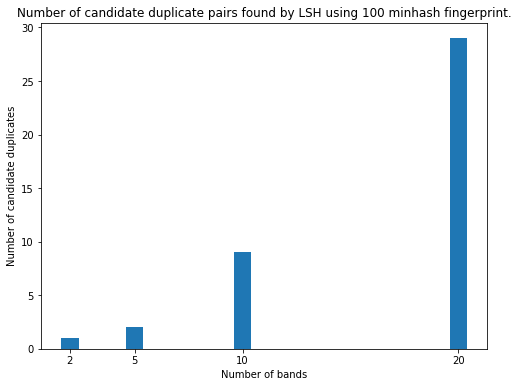

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(bands, num_candidates, align='center');
plt.title('Number of candidate duplicate pairs found by LSH using 100 minhash fingerprint.');
plt.xlabel('Number of bands');
plt.ylabel('Number of candidate duplicates');
plt.xticks(bands, bands);


---
## Up Next : 

[Train your own GPTBPE Tokenizer on your own data ](../../../Day3-3_train_own_GPT2BPETokenizer.ipynb)

## Back To Start Menu
[start menu](../../../../Start_Here.ipynb)

-----


## Licensing 

This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0). 